This notebook can be used to explore when two climate scenarios from IM3 diverge from one another statistically. The divergence is calculated on the BA-level meteorology time-series processed as part of the wrf-to-tell processing pipeline. Notes on the KS statistical test can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html.

In [142]:
# Start by importing the necessary libraries:
import os
import glob
import tell

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from scipy import stats
from joblib import Parallel, delayed

In [125]:
# Identify data where the wrf_to_tell output data is stored:
data_input_dir = '/Volumes/LaCie/wrf_to_tell/wrf_tell_bas_output/'

# Set the alpha parameter to judge statistical significance:
alpha = 0.01

# Set the two scenarios to compare:
scenario_one = 'CONUS_TGW_WRF_SSP585_COLD'
scenario_two = 'CONUS_TGW_WRF_SSP585_HOT'


In [130]:
# Define a function to process the statistical difference significance timeline for BAs:
def process_ba_ss_timeline(ba_to_process: str, start_year: int, end_year: int, met_variable: str, alpha: int):
    """Compute a timeline of the statistical difference significance between scenario_one and scenario_two for a given BA and meteorological variable.

    :param ba_to_process:       Code of the BA you want to process
    :type ba_to_process:        str
    
    :param start_year:          Four digit year to start the timeline (e.g., 2020)
    :type start_year:           int
    
    :param end_year:            Four digit year to end the timeline (e.g., 2020)
    :type end_year:             int
    
    :param met_variable:        Meteorological variable you want to compare: T2, Q2, SWDOWN, GLW, WSPD
    :type met_variable:         str
    
    :param alpha:               Alpha parameter to judge statistical significance
    :type alpha:                int

    :return:                    DataFrame of the time-series of statistical difference significance

    """

    for year in range(start_year, end_year+1, 1):
        # Load meteorological time-series for scenario_one:
        s1_df = pd.read_csv((os.path.join(data_input_dir, scenario_one, (ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv'))), 
                             index_col=None, header=0)
    
        # Load meteorological time-series for scenario_two:
        s2_df = pd.read_csv((os.path.join(data_input_dir, scenario_two, (ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv'))), 
                             index_col=None, header=0)
    
        # Compute the two-sample discrete Kolmogorov-Smirnov test for goodness of fit:
        test_stat = stats.ks_2samp(s1_df[met_variable], s2_df[met_variable])
    
        # Extract the test significance to a new dataframe:
        stat_df = pd.DataFrame()
        stat_df.at[0, 'BA'] = ba_to_process
        stat_df.at[0, met_variable] = met_variable
        stat_df.at[0, 'Year'] = str(year)
        stat_df.at[0, 'KS_Statistic'] = test_stat.statistic
        stat_df.at[0, 'KS_PValue'] = test_stat.pvalue
        
        # Set the significance to 1 for p-values that are less than the alpha parameter and 0 otherwise:
        stat_df['Significant'] = 0
        stat_df.loc[(stat_df['KS_PValue'] < alpha), 'Significant'] = 1
        
        # Round off some values to make the output easier to read:
        stat_df['KS_Statistic'] = stat_df['KS_Statistic'].round(5)
        stat_df['KS_PValue'] = stat_df['KS_PValue'].round(5)
        
        # Concatenate the results across years:
        if year == start_year:
            output_df = stat_df
        else:
            output_df = pd.concat([output_df, stat_df])
        
    return output_df


In [131]:
# Process the timeline for a single BA as an example:
df = process_ba_ss_timeline('PJM', 2020, 2099, 'T2', alpha)

df

,BA,T2,Year,KS_Statistic,KS_PValue,Significant
0,PJM,T2,2020,0.01992,0.06119,0
0,PJM,T2,2021,0.01838,0.10373,0
0,PJM,T2,2022,0.02169,0.03245,0
0,PJM,T2,2023,0.02078,0.04558,0
0,PJM,T2,2024,0.02106,0.04063,0
...,...,...,...,...,...,...
0,PJM,T2,2095,0.08196,0.00000,1
0,PJM,T2,2096,0.07639,0.00000,1
0,PJM,T2,2097,0.09018,0.00000,1
0,PJM,T2,2098,0.09075,0.00000,1


In [132]:
# Define a function to batch process a list of BAs:
def process_ba_ss_timeline_batch(ba_list: list, start_year: int, end_year: int, met_variable: str, alpha: int, n_jobs: int = -1):
    # Process all the BAs in the list in parallel:
    results = Parallel(n_jobs=n_jobs, backend="loky")(delayed(process_ba_ss_timeline)(ba_to_process = region,
                                                                                      start_year = start_year,
                                                                                      end_year = end_year,
                                                                                      met_variable = met_variable, 
                                                                                      alpha = alpha
                                                                                      ) for region in ba_list)

    # Aggregate the outputs:
    for index, i in enumerate(results):
        if index == 0:
            output_df = i
        else:
            output_df = pd.concat([output_df, i])

    return output_df


In [133]:
df = process_ba_ss_timeline_batch((tell.get_balancing_authority_to_model_dict().keys()), 2020, 2099, 'T2', alpha)

df

,BA,T2,Year,KS_Statistic,KS_PValue,Significant
0,AEC,T2,2020,0.01742,0.13912,0
0,AEC,T2,2021,0.02203,0.02846,0
0,AEC,T2,2022,0.03196,0.00026,1
0,AEC,T2,2023,0.02957,0.00094,1
0,AEC,T2,2024,0.03518,0.00004,1
...,...,...,...,...,...,...
0,WAUW,T2,2095,0.07534,0.00000,1
0,WAUW,T2,2096,0.07343,0.00000,1
0,WAUW,T2,2097,0.07648,0.00000,1
0,WAUW,T2,2098,0.08139,0.00000,1


/var/folders/2x/xdz7fwts5fj0gdl0b7lbtc_cbqnqwx/T/ipykernel_60593/1986026845.py:3: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  z = sp.array(df['Significant'])
/var/folders/2x/xdz7fwts5fj0gdl0b7lbtc_cbqnqwx/T/ipykernel_60593/1986026845.py:5: DeprecationWarning: scipy.meshgrid is deprecated and will be removed in SciPy 2.0.0, use numpy.meshgrid instead
  Y, X = sp.meshgrid(y, x)


TypeError: unhashable type: 'numpy.ndarray'

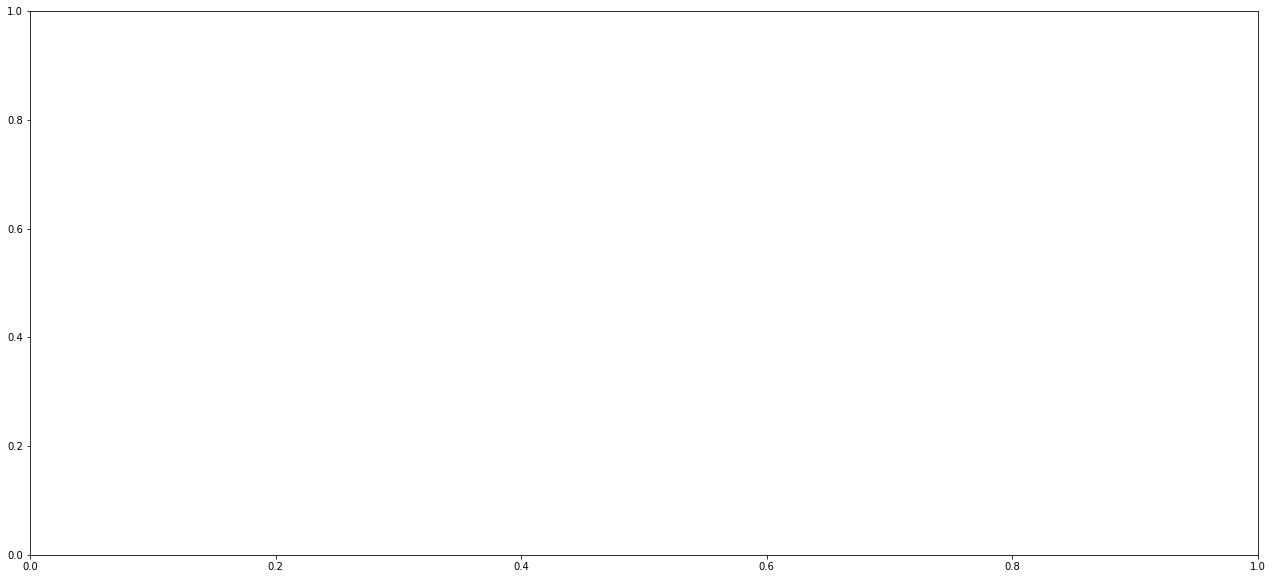

In [151]:
x = df['BA'].values
y = df['Year'].values
z = sp.array(df['Significant'])

Y, X = sp.meshgrid(y, x)

plt.figure(figsize=(22,10))
plt.pcolor(X, Y, z)
